# Internal Injection Analysis for Pedestal Stability Studies

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re

In [73]:
# === CONFIGURATION ===
data_dir = Path("/home/lorena/Documents/PhD/EEEMCal_Analysis/Pedestal_Stability/Data")
dac_values = [100, 200, 300, 400]
conditions = ["HV", "NoHV"]
fpga_to_pb = {209: "008", 210: "06"}

# Plots output directory
plot_dir = Path("/home/lorena/Documents/PhD/EEEMCal_Analysis/Pedestal_Stability/Plots")
plot_dir.mkdir(parents=True, exist_ok=True)

In [74]:
# channels to ignore
dead_channels = {0, 37, 38, 75, 76, 113, 114, 151}
calibration_channels = {19, 57, 95, 133}
notConnected_channels = {9, 18, 28, 47, 56, 66, 85, 94, 104, 123, 132, 142}
ignore_channels = dead_channels | calibration_channels | notConnected_channels

In [75]:
# === FUNCTION TO READ AND PROCESS A FILE ===
def process_file(filepath):
    df = pd.read_csv(filepath)
    df = df[~df["Phase"].isin([4, 6, 7])]
    df = df[~df["Channel"].isin(ignore_channels)]
    return df.groupby("Channel")["ADC"].max().reset_index(name="ADC_max")

In [76]:
# === FUNCTION TO OBTAIN STATISTICS PER FPGA/DAC/HV ===
def aggregate_by_condition(fpga):
    pb = fpga_to_pb[fpga]
    results = []

    for dac in dac_values:
        for cond in conditions:
            folder = data_dir / f"{dac}_DAC_{cond}"
            pattern = rf"inj_adc_samples_{fpga}_pb{pb}_\d+_{dac}_(\d+)_{cond}.csv"
            
            all_runs = []
            for file in folder.glob("*.csv"):
                if re.search(pattern, file.name):
                    run_df = process_file(file)
                    run_df["Run"] = int(re.search(pattern, file.name).group(1))
                    all_runs.append(run_df)
            
            if not all_runs:
                print(f"No files for FPGA {fpga}, DAC {dac}, {cond}")
                continue

            merged = pd.concat(all_runs)
            stats = merged.groupby("Channel")["ADC_max"].agg(["mean", "std"]).reset_index()
            stats["FPGA"] = fpga
            stats["DAC"] = dac
            stats["Condition"] = cond
            results.append(stats)
    
    return pd.concat(results, ignore_index=True) if results else pd.DataFrame()

## Maximum ADC values per Channel with pedestals

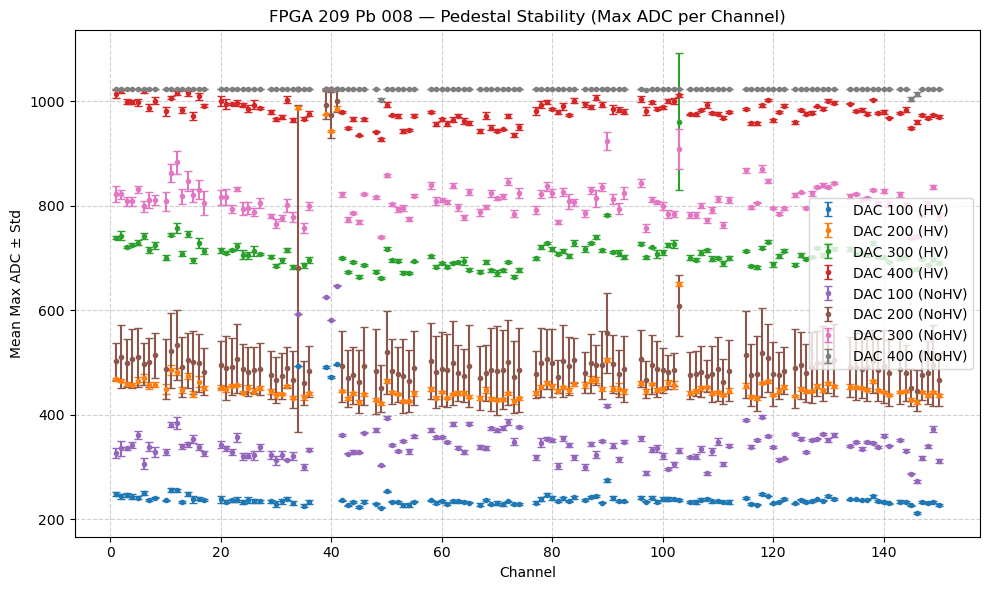

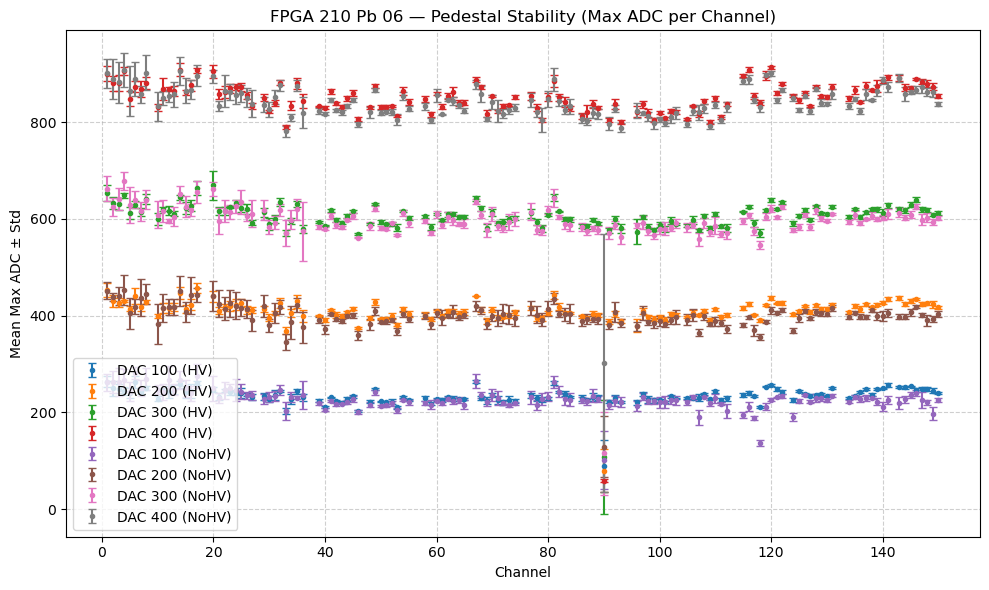

In [77]:
# === ANALYSE BOTH FPGAs ===
summary_all = pd.concat([aggregate_by_condition(fpga) for fpga in fpga_to_pb.keys()], ignore_index=True)

# === PLOT ===
def plot_fpga(summary, fpga):
    plt.figure(figsize=(10,6))
    subset = summary[summary["FPGA"] == fpga]
    
    for cond in conditions:
        for dac in dac_values:
            sel = subset[(subset["DAC"] == dac) & (subset["Condition"] == cond)]
            if sel.empty:
                continue
            plt.errorbar(
                sel["Channel"], sel["mean"], yerr=sel["std"],
                label=f"DAC {dac} ({cond})", fmt='.', capsize=3
            )

    plt.title(f"FPGA {fpga} Pb {fpga_to_pb[fpga]} — Pedestal Stability (Max ADC per Channel)")
    plt.xlabel("Channel")
    plt.ylabel("Mean Max ADC ± Std")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

for fpga in fpga_to_pb.keys():
    plot_fpga(summary_all, fpga)

## Maximum ADC values per channel without pedestals

In [78]:
# CSV route with pedestals
ped_csv = Path("/home/lorena/Documents/PhD/EEEMCal_Analysis/Pedestal_Stability/Data/Pedestals/pedestals_HV_vs_NoHV_FPGA209_210.csv")

# Load pedestals (columns: FPGA, PB, Channel, NoHV, HV)
ped_df = pd.read_csv(ped_csv)

# Ensure consistent types with summary_all (your summary uses FPGA as an int)
ped_df["FPGA"] = ped_df["FPGA"].astype(int)
ped_df["Channel"] = ped_df["Channel"].astype(int)

# Pasar a formato largo para poder hacer merge por Condition
# It will contain: (FPGA, PB, Channel, Condition, Pedestal)
ped_long = ped_df.melt(
    id_vars=["FPGA", "PB", "Channel"],
    value_vars=["NoHV", "HV"],
    var_name="Condition",
    value_name="Pedestal"
)

# (optional) sanity check
print(ped_long.head())

   FPGA  PB  Channel Condition  Pedestal
0   209   8        1      NoHV     101.0
1   209   8        2      NoHV      96.0
2   209   8        3      NoHV      95.0
3   209   8        4      NoHV      95.0
4   209   8        5      NoHV      97.0


In [79]:
# Merge left: we want to keep all the (FPGA, Channel, Condition) that we have in summary_all
summary_with_ped = summary_all.merge(
    ped_long[["FPGA", "Channel", "Condition", "Pedestal"]],
    on=["FPGA", "Channel", "Condition"],
    how="left",
    validate="many_to_one"  # por canal/condición debe haber un único pedestal
)

# Chequeo de faltantes
missing = summary_with_ped["Pedestal"].isna().sum()
if missing > 0:
    print(f"⚠️ Pedestal faltante en {missing} filas (revisa coincidencia de FPGA/Channel/Condition).")

# Subtract pedestal: (the standard deviation does not change, as the pedestal is constant per channel)
summary_with_ped["mean_corr"] = summary_with_ped["mean"] - summary_with_ped["Pedestal"]
summary_with_ped["std_corr"]  = summary_with_ped["std"]

# Vista rápida
summary_with_ped.head()

,Channel,mean,std,FPGA,DAC,Condition,Pedestal,mean_corr,std_corr
0,1,249.4,4.159327,209,100,HV,81.0,168.4,4.159327
1,2,244.4,4.722288,209,100,HV,79.0,165.4,4.722288
2,3,247.4,3.974921,209,100,HV,79.0,168.4,3.974921
3,4,243.8,4.086563,209,100,HV,78.0,165.8,4.086563
4,5,241.8,2.949576,209,100,HV,81.0,160.8,2.949576


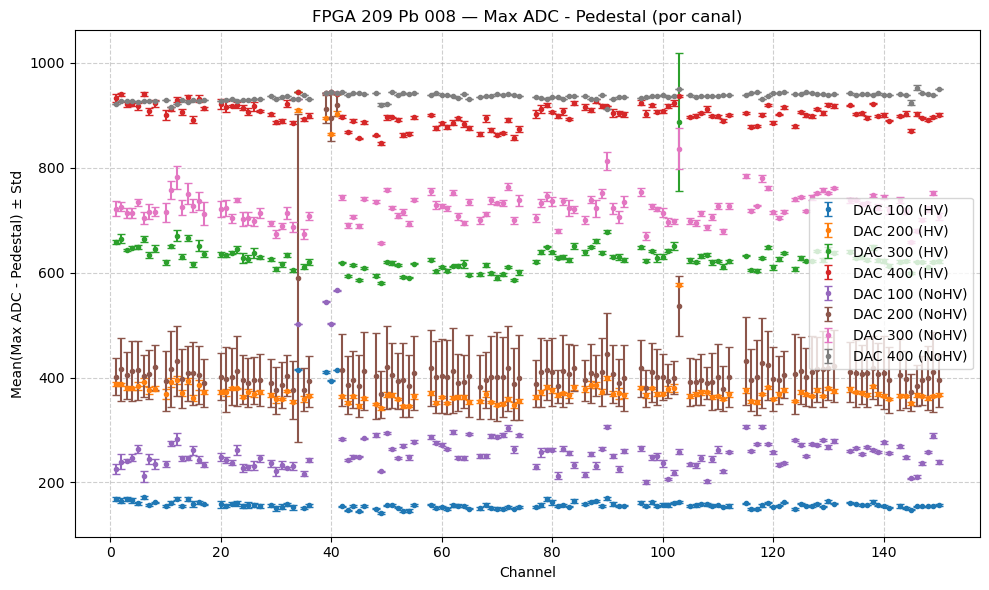

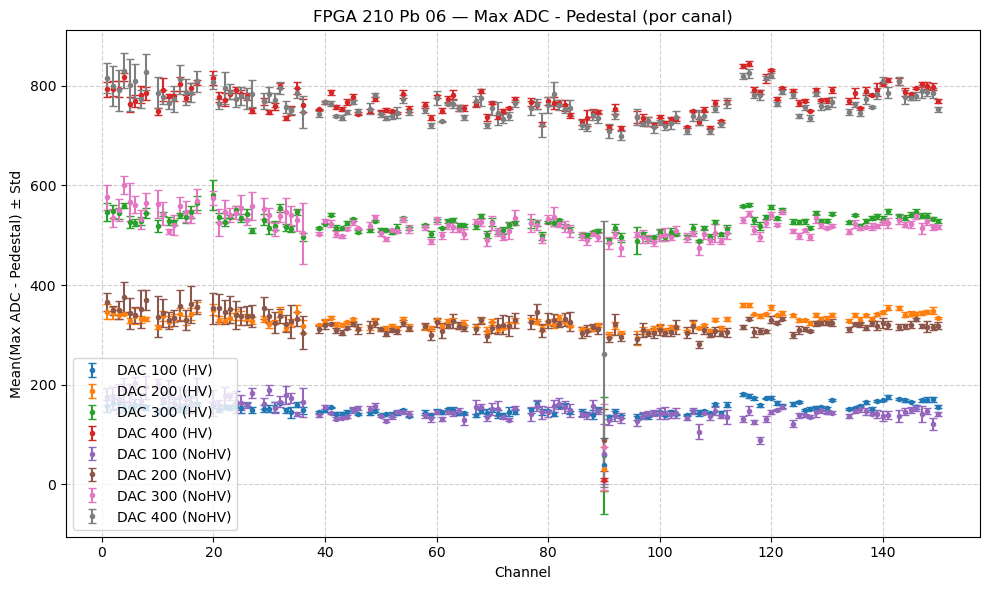

In [80]:
def plot_fpga_ped_subtracted(summary_corr, fpga, fpga_to_pb):
    plt.figure(figsize=(10,6))
    subset = summary_corr[summary_corr["FPGA"] == fpga]
    
    for cond in conditions:          # ["HV", "NoHV"]
        for dac in dac_values:       # [100, 200, 300, 400]
            sel = subset[(subset["DAC"] == dac) & (subset["Condition"] == cond)]
            if sel.empty:
                continue
            plt.errorbar(
                sel["Channel"], sel["mean_corr"], yerr=sel["std_corr"],
                label=f"DAC {dac} ({cond})", fmt='.', capsize=3
            )

    plt.title(f"FPGA {fpga} Pb {fpga_to_pb[fpga]} — Max ADC - Pedestal (por canal)")
    plt.xlabel("Channel")
    plt.ylabel("Mean(Max ADC - Pedestal) ± Std")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

for fpga in fpga_to_pb.keys():
    plot_fpga_ped_subtracted(summary_with_ped, fpga, fpga_to_pb)

In [81]:
out_corr = Path("/home/lorena/Documents/PhD/EEEMCal_Analysis/Pedestal_Stability/Data/Pedestals/summary_maxADC_minus_pedestal.csv")
cols = ["FPGA", "DAC", "Condition", "Channel", "mean", "std", "Pedestal", "mean_corr", "std_corr"]
summary_with_ped[cols].sort_values(["FPGA","DAC","Condition","Channel"]).to_csv(out_corr, index=False)
print(f"✅ CSV (pedestal-subtracted) saved in: {out_corr}")

✅ CSV (pedestal-subtracted) saved in: /home/lorena/Documents/PhD/EEEMCal_Analysis/Pedestal_Stability/Data/Pedestals/summary_maxADC_minus_pedestal.csv


### Plots ignoring bad channels

In [82]:
# Channels to ignore in the plots (not removed from data, only hidden)
ignore_plot_channels = {
    209: {105, 97, 107, 99, 101, 103},   # FPGA 209 / PB 008
    210: {36, 77, 90, 96},                # FPGA 210 / PB 06
}

In [83]:
def plot_fpga_ped_subtracted_filtered(summary_corr, fpga, fpga_to_pb, ignore_plot_channels):
    plt.figure(figsize=(10,6))
    subset = summary_corr[summary_corr["FPGA"] == fpga]

    # Exclude channels listed for this FPGA (only for plotting)
    subset = subset[~subset["Channel"].isin(ignore_plot_channels.get(fpga, set()))]
    
    for cond in conditions:          # ["HV", "NoHV"]
        for dac in dac_values:       # [100, 200, 300, 400]
            sel = subset[(subset["DAC"] == dac) & (subset["Condition"] == cond)]
            if sel.empty:
                continue
            plt.errorbar(
                sel["Channel"], sel["mean_corr"], yerr=sel["std_corr"],
                label=f"DAC {dac} ({cond})", fmt='.', capsize=3
            )

    plt.title(f"FPGA {fpga} Pb {fpga_to_pb[fpga]} — Max ADC - Pedestal (filtered)")
    plt.xlabel("Channel")
    plt.ylabel("Mean(Max ADC - Pedestal) ± Std")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    
    # === Save plot ===
    filename = f"fpga{fpga}_pb{fpga_to_pb[fpga]}_ADCminusPedestal_filtered.png"
    out_path = plot_dir / filename
    plt.savefig(out_path, dpi=300)
    plt.show()
    plt.close()
    print(f"✅ Saved plot: {out_path}")

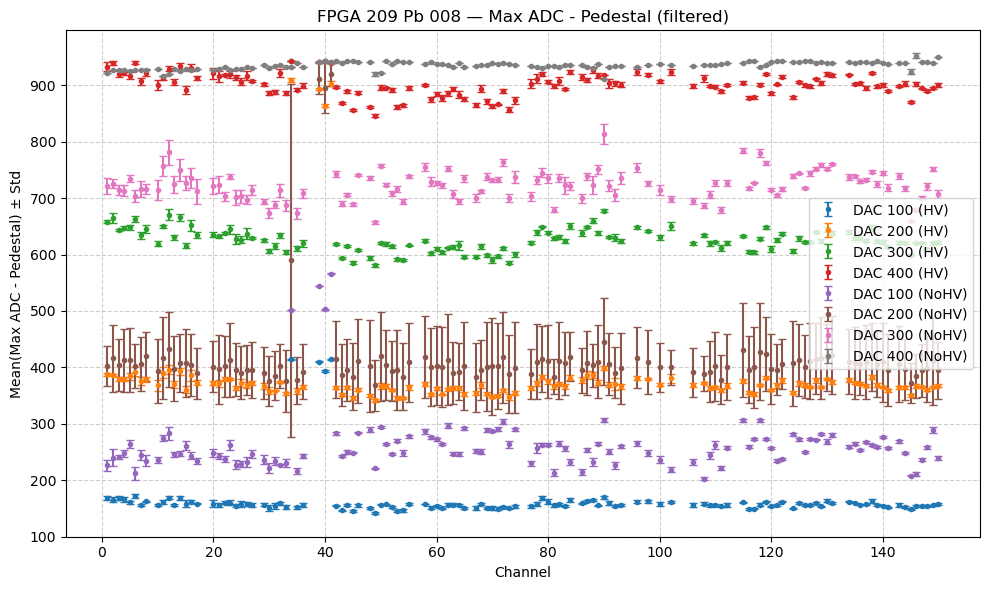

✅ Saved plot: /home/lorena/Documents/PhD/EEEMCal_Analysis/Pedestal_Stability/Plots/fpga209_pb008_ADCminusPedestal_filtered.png


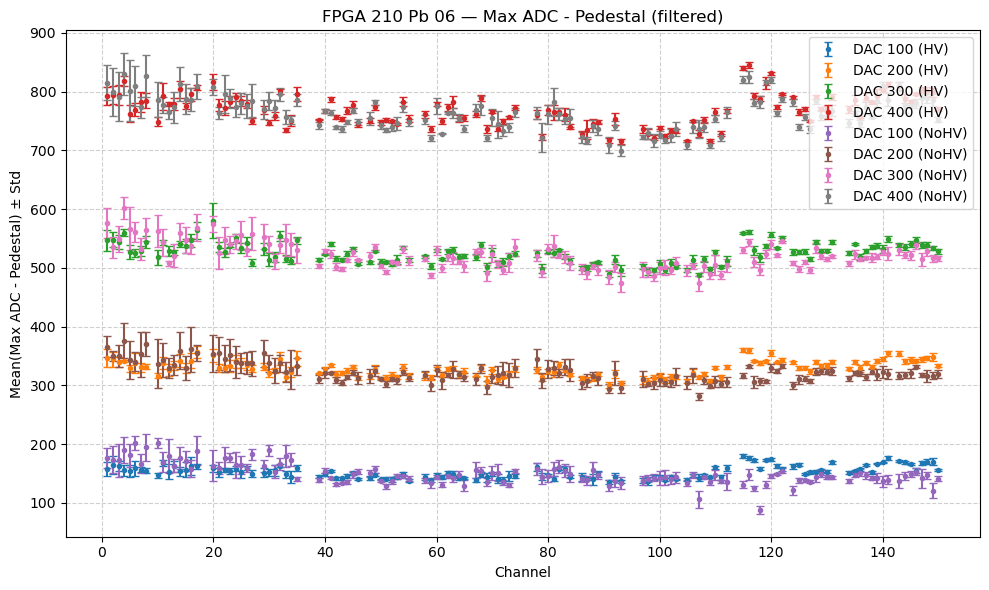

✅ Saved plot: /home/lorena/Documents/PhD/EEEMCal_Analysis/Pedestal_Stability/Plots/fpga210_pb06_ADCminusPedestal_filtered.png


In [84]:
for fpga in fpga_to_pb.keys():
    plot_fpga_ped_subtracted_filtered(summary_with_ped, fpga, fpga_to_pb, ignore_plot_channels)
